In [1]:
!pip install econml==0.14.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 15.3 MB/s eta 0:00:00


In [2]:
from econml.metalearners import TLearner, SLearner, XLearner
from econml.dr import DRLearner
from econml.dml import DML, LinearDML, CausalForestDML
import numpy as np
from numpy.random import binomial, multivariate_normal, normal, uniform
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/usr/local/lib/python3.10/dist-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_masks, max_swap_size=100, num_

In [3]:
def generate_data(n, d, controls_outcome, treatment_effect, propensity):
    # 共変量の生成
    X = multivariate_normal(np.zeros(d), np.diag(np.ones(d)), n)# 平均が0で、共分散が単位行列である多変量正規分布から共変量を生成
    # 処置変数の生成
    T = np.apply_along_axis(lambda x: binomial(1, propensity(x), 1)[0], 1, X)
    # 結果変数の生成
    Y0 = np.apply_along_axis(lambda x: controls_outcome(x), 1, X)
    treat_effect = np.apply_along_axis(lambda x: treatment_effect(x), 1, X)
    Y = Y0 + treat_effect * T
    return (Y, T, X)

In [4]:
np.random.seed(1)
d = 10
n = 1000
def generate_controls_outcome(d):
    beta = uniform(-2, 2, d)
    return lambda x: np.dot(x, beta) + normal(0, 1)
controls_outcome = generate_controls_outcome(d)
treatment_effect = lambda x: 10 if x[1] > 1 else (5 if x[1] > 0.1 else 0)
propensity = lambda x: (0.7 if (x[2]>-0.5 and x[2]<0.5) else 0.3)
Y, T, X = generate_data(n, d, controls_outcome, treatment_effect, propensity)

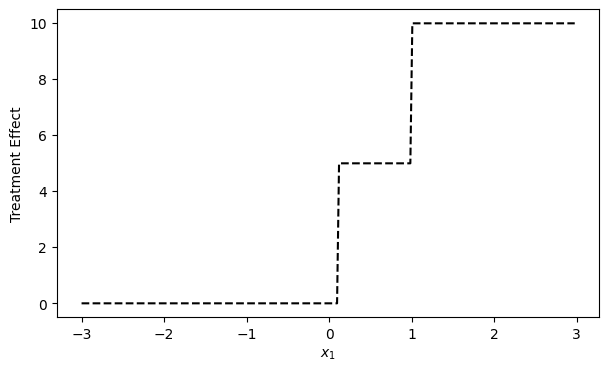

In [5]:
# 実際の処置効果の計算・可視化
n_test = 250
X_test = multivariate_normal(np.zeros(d), np.diag(np.ones(d)), n_test)
delta = 6/n_test
X_test[:, 1] = np.arange(-3, 3, delta)
true_effects = np.array([treatment_effect(x) for x in X_test])
plt.figure(figsize=(7, 4))
plt.plot(X_test[:, 1], np.apply_along_axis(treatment_effect, 1, X_test), color='black', ls='--', label='Baseline')
plt.xlabel('$x_1$')
plt.ylabel('Treatment Effect')
plt.show()

In [6]:
#Base modelの設定
GBR=GradientBoostingRegressor()
GBC=GradientBoostingClassifier()

# モデルの初期化
models_DML = {
    'LinearDML':LinearDML(model_y=GBR, # Y(結果変数)のモデルとして勾配ブースティングによる回帰を使用
                          model_t=GBC, # T(処置変数)のモデルとして勾配ブースティングによる分類を使用
                          discrete_treatment=True, # 処置が離散的であることを示す
                          cv=6), # 6-fold クロスバリデーションを使用

    'CausalForestDML':CausalForestDML(model_y=GBR, # Y(結果変数)のモデルとして勾配ブースティングによる回帰を使用
                                      model_t=GBC, # T(処置変数)のモデルとして勾配ブースティングによる分類を使用
                                      discrete_treatment=True, # 処置が離散的であることを示す
                                      cv=6) # 6-fold クロスバリデーションを使用
    }

# モデルの学習と評価
np.random.seed(1) # 乱数のシードを設定
results_DML = {}
for name, model in models_DML.items():
  model.fit(Y, T, X=X)
  preds = model.effect(X_test)
  mse = mean_squared_error(true_effects, preds)
  results_DML[name] = mse
results_DML

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


{'LinearDML': 7.023871510948287, 'CausalForestDML': 0.2926810063627793}

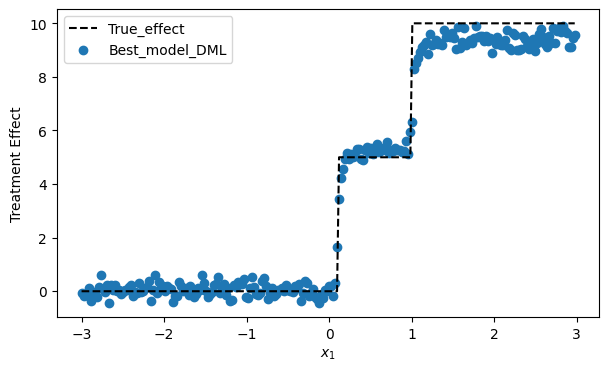

In [7]:
# 最も精度の高いモデルを選択し、テストデータセットに対する処置効果を推定
best_model_name_DML = min(results_DML, key=results_DML.get)
best_model_DML = models_DML[best_model_name_DML]
DML_pred = best_model_DML.effect(X_test) # X_testに基づいて処置効果を予測

# 結果を可視化
plt.figure(figsize=(7, 4))
plt.plot(X_test[:, 1], np.apply_along_axis(treatment_effect, 1, X_test),
color='black', ls='--', label='True_effect')
plt.scatter(X_test[:, 1], DML_pred, label="Best_model_DML")
plt.xlabel('$x_1$')
plt.ylabel('Treatment Effect')
plt.legend()
plt.show()

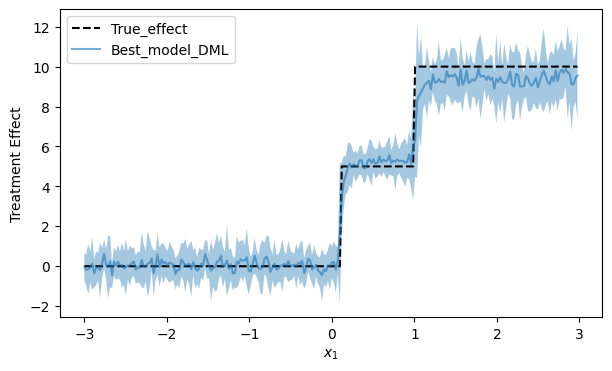

In [8]:
#信頼区間の表示
lb, ub = best_model_DML.effect_interval(X_test, alpha=0.01)

#結果を可視化
plt.figure(figsize=(7, 4))
plt.plot(X_test[:, 1], np.apply_along_axis(treatment_effect, 1, X_test),
color='black', ls='--', label='True_effect')
plt.plot(X_test[:, 1], DML_pred, label="Best_model_DML", alpha=.6)
plt.fill_between(X_test[:, 1], lb, ub, alpha=.4)
plt.xlabel('$x_1$')
plt.ylabel('Treatment Effect')
plt.legend(loc='upper left')
plt.show()